# H₃⁺ Excited States via Subspace-Search Variational Quantum Eigensolver (SSVQE)

This notebook computes the ground and first excited states of the **Trihydrogen Cation (H₃⁺)** using the **SSVQE** algorithm.

- Molecule: H₃⁺ (Equilateral triangle, 2 electrons)
- Ansatz: UCC-style excitations (singles + doubles)
- Optimizer: Adam
- Goal: Minimize both E₀ and E₁ with orthogonality enforced
- Device: Noiseless statevector simulator

In [ ]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
import matplotlib.pyplot as plt
import sys, os, json
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from src.vqe_utils import excitation_ansatz, get_optimizer, set_seed, make_run_config_dict, run_signature, find_existing_run, save_run_record, ensure_dirs, build_run_filename
from src.vqe_utils import RESULTS_DIR, IMG_DIR

seed = 0
set_seed(seed)  # Reproducible runs
ensure_dirs()   # Creates results/ and images/, if missing

[saved] Adam: runs/H3+_SSVQE_Adam_s0__e24197916e44.json
[mirrored] results/H3+_SSVQE_Adam_s0__e24197916e44.json


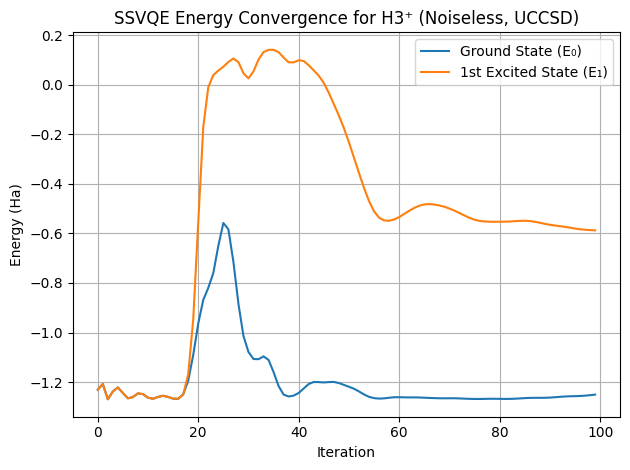

In [ ]:
# Molecular setup:

symbols = ["H", "H", "H"]
coordinates = np.array([
    [0.000000,  1.000000,  0.000000],
    [-0.866025, -0.500000, 0.000000],
    [ 0.866025, -0.500000, 0.000000]
])

basis = "STO-3G"
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=+1, basis=basis)

electrons = 2
hf = qchem.hf_state(electrons, qubits)

singles, doubles = qchem.excitations(electrons, qubits)
singles = [tuple(x) for x in singles]
doubles = [tuple(x) for x in doubles]
n_params = len(singles) + len(doubles)
num_wires = qubits

# Device & QNodes
dev = qml.device("default.qubit", wires=num_wires)

def state_circuit(params):
    excitation_ansatz(params, wires=range(num_wires), hf_state=hf, excitations=(singles, doubles))

@qml.qnode(dev)
def energy_expectation(params):
    state_circuit(params)
    return qml.expval(hamiltonian)

@qml.qnode(dev)
def overlap(params1, params2):
    excitation_ansatz(params1, wires=range(num_wires), hf_state=hf, excitations=(singles, doubles))
    qml.adjoint(state_circuit)(params2)
    return qml.probs(wires=range(num_wires))

def overlap00(p0, p1):
    return overlap(p0, p1)[0]

# Cache-aware SSVQE run
def run_ssvqe_with_cache(stepsize=0.4, max_iter=75, penalty_weight=10.0):
    # Ansatz description for logging
    ansatz_desc = "SSVQE with UCC singles+doubles (two states, orthogonality penalty)"

    # Build configuration and signature
    optimizer_name = "Adam"
    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iter,
        seed=seed,
    )

    cfg["penalty_weight"] = float(penalty_weight)

    # Canonical file name: readable prefix and signature
    sig = run_signature(cfg)
    fname = build_run_filename("H3+_SSVQE", optimizer_name, seed, sig)
    existing = find_existing_run(sig)

    if existing:
        # Load results if this configuration has been run before
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] loaded {existing}")
        E0_list = rec["E0_list"]; E1_list = rec["E1_list"]
        return {"E0_list": E0_list, "E1_list": E1_list, "final_params": rec.get("final_params")}

    # Compute results if this configuration has NOT been ran before
    def ssvqe_cost(params):
        p0, p1 = params[:n_params], params[n_params:]
        E0 = energy_expectation(p0)
        E1 = energy_expectation(p1)
        penalty = penalty_weight * overlap00(p0, p1)
        return E0 + E1 + penalty

    params = np.zeros(2 * n_params, requires_grad=True)
    opt = get_optimizer(optimizer_name, stepsize=stepsize)

    E0_list, E1_list = [], []
    for _ in range(max_iter):
        params, _ = opt.step_and_cost(ssvqe_cost, params)
        p0, p1 = params[:n_params], params[n_params:]
        E0_list.append(float(energy_expectation(p0)))
        E1_list.append(float(energy_expectation(p1)))

    run_record = {
        "timestamp": __import__("time").strftime("%Y-%m-%d %H:%M:%S"),
        "molecule": "H3+",
        "symbols": symbols,
        "geometry": coordinates.tolist(),
        "basis": basis,
        "electrons": electrons,
        "num_wires": num_wires,
        "algorithm": "SSVQE",
        "ansatz": ansatz_desc,
        "optimizer": {"name": optimizer_name, "stepsize": stepsize,
                      "iterations_planned": max_iter, "iterations_ran": len(E0_list)},
        "seed": seed,
        "penalty_weight": penalty_weight,
        "E0_list": E0_list,
        "E1_list": E1_list,
        "final_params": [float(x) for x in params],
        "config_hash": sig,
    }

    persisted = save_run_record(fname, run_record)
    print(f"[saved] {optimizer_name}: {fname}")
    print(f"[mirrored] {persisted}")
    return {"E0_list": E0_list, "E1_list": E1_list, "final_params": params}

res = run_ssvqe_with_cache(stepsize=0.4, max_iter=100, penalty_weight=10.0)
E0_list, E1_list = res["E0_list"], res["E1_list"]
params = res["final_params"]

# Plot energy convergence
plt.plot(E0_list, label="Ground State (E₀)")
plt.plot(E1_list, label="1st Excited State (E₁)")
plt.xlabel("Iteration"); plt.ylabel("Energy (Ha)")
plt.title("SSVQE Energy Convergence for H3⁺ (Noiseless, UCCSD)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_SSVQE_Adam.png", dpi=300); plt.show()

In [5]:
# Final state summary:
final_E0 = E0_list[-1]
final_E1 = E1_list[-1]
delta_E = final_E1 - final_E0

print(f"Final Ground State Energy (E₀): {final_E0:.8f} Ha")
print(f"Final Excited State Energy (E₁): {final_E1:.8f} Ha")
print(f"Excitation Energy ΔE = E₁ - E₀: {delta_E:.8f} Ha")

Final Ground State Energy (E₀): -1.25054229 Ha
Final Excited State Energy (E₁): -0.58759689 Ha
Excitation Energy ΔE = E₁ - E₀: 0.66294540 Ha


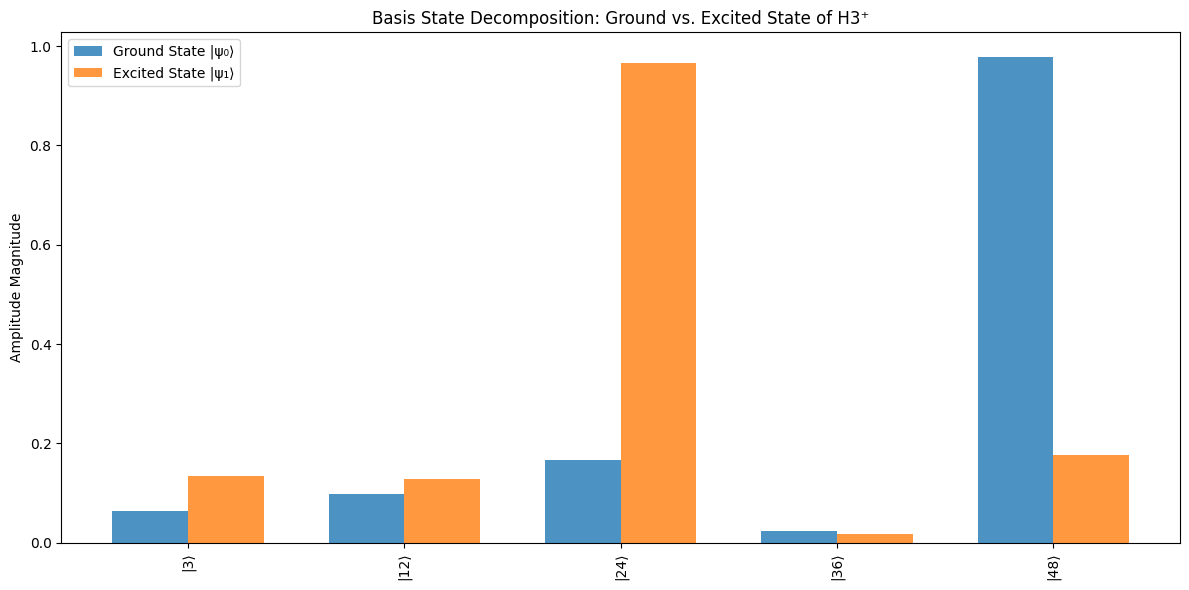

In [6]:
# State comparison/visualization:
@qml.qnode(dev)
def get_state(params):
    excitation_ansatz(params, wires=range(num_wires), hf_state=hf, excitations=(singles, doubles))
    return qml.state()

# Evaluate both final statevectors
psi_0 = get_state(params[:n_params])
psi_1 = get_state(params[n_params:])

# Filter significant amplitudes
threshold = 1e-2

# Indices where either state has non-zero amplitude above threshold
non_zero_indices = np.unique(np.where(
    (np.abs(psi_0) > threshold) | (np.abs(psi_1) > threshold)
)[0])

basis_labels = [f"|{i}⟩" for i in non_zero_indices]   # decimal labels for readability
amp_0 = [np.abs(psi_0[i]) for i in non_zero_indices]
amp_1 = [np.abs(psi_1[i]) for i in non_zero_indices]

# Plot
x = np.arange(len(basis_labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, amp_0, width, label='Ground State |ψ₀⟩', alpha=0.8)
plt.bar(x + width/2, amp_1, width, label='Excited State |ψ₁⟩', alpha=0.8)
plt.xticks(x, basis_labels, rotation=90)
plt.ylabel("Amplitude Magnitude")
plt.title("Basis State Decomposition: Ground vs. Excited State of H3⁺")
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3+_SSVQE_State_Comparison.png", dpi=300)
plt.show()